# Imports

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
import tensorflow as tf
import cv2

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
epochs = 30

In [ ]:
files = glob(r'Datasets\Car-Bike-Dataset\*\*.*')

len(files)

4000

In [ ]:
label = [file.split('\\')[2] for file in files]

In [ ]:
set(label)

{'Bike', 'Car'}

In [ ]:
df = pd.DataFrame({'file_path' : files,
                   'label': label})
df.head()

,file_path,label
0,Datasets\Car-Bike-Dataset\Bike\Bike (1).jpeg,Bike
1,Datasets\Car-Bike-Dataset\Bike\Bike (1).jpg,Bike
2,Datasets\Car-Bike-Dataset\Bike\Bike (1).png,Bike
3,Datasets\Car-Bike-Dataset\Bike\Bike (10).jpeg,Bike
4,Datasets\Car-Bike-Dataset\Bike\Bike (10).jpg,Bike


In [ ]:
df['file_path'].str.split('.').apply(lambda x : x[-1]).

jpeg    3731
jpg      235
png       30
JPG        4
Name: file_path, dtype: int64

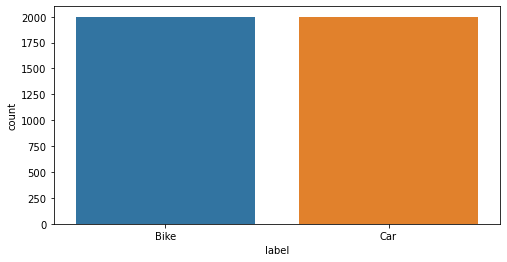

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x =df['label'])
plt.show()

In [ ]:
df_train , df_val =train_test_split(
    df, test_size=0.2,
    random_state=1, stratify=df['label']
)

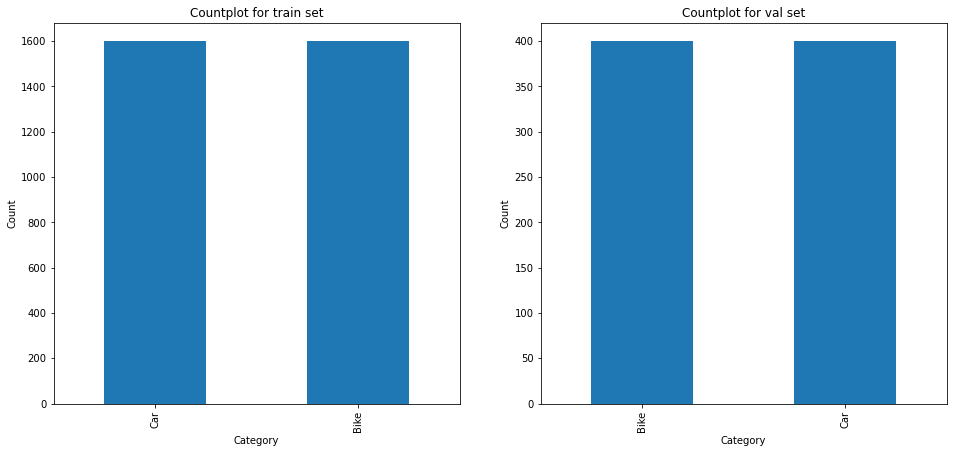

In [ ]:
fig, ax = plt.subplots(figsize=(16,7), nrows=1,ncols=2)
df_train['label'].value_counts().plot(ax=ax[0],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for train set')
df_val['label'].value_counts().plot(ax=ax[1],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for val set')
plt.show()

In [ ]:
train_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

# Only rescaling the val set
val_gen = ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

In [ ]:
train_set = train_gen.flow_from_dataframe(
    df_train, 
    x_col='file_path',
    y_col='label',
    target_size=(IMAGE_SIZE,IMAGE_SIZE), 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=BATCH_SIZE)
val_set = val_gen.flow_from_dataframe(
    df_val , 
    x_col='file_path',
    y_col='label',
    target_size=(IMAGE_SIZE,IMAGE_SIZE), 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=BATCH_SIZE)

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [ ]:
class_dict = {v:k for k,v in train_set.class_indices.items()}
class_dict
NUM_CLASS = len(class_dict)

In [ ]:
def see_examples(datagen, figsize=(16,16),nrows=4, ncols=4):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    batch_idx = np.random.randint(low=0, high=len(datagen), size=(nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            imgs, labels = datagen[batch_idx[i,j]]
            sample_idx = np.random.randint(low=0, high=len(imgs))
            img = imgs[sample_idx]
            label = labels[sample_idx]
            label = class_dict[np.argmax(label)]
            ax[i,j].axis('off')
            ax[i,j].imshow(img)
            ax[i,j].set_title(label)
    plt.show()

C:\Users\mmmmmm\anaconda3\envs\Deeplearning\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


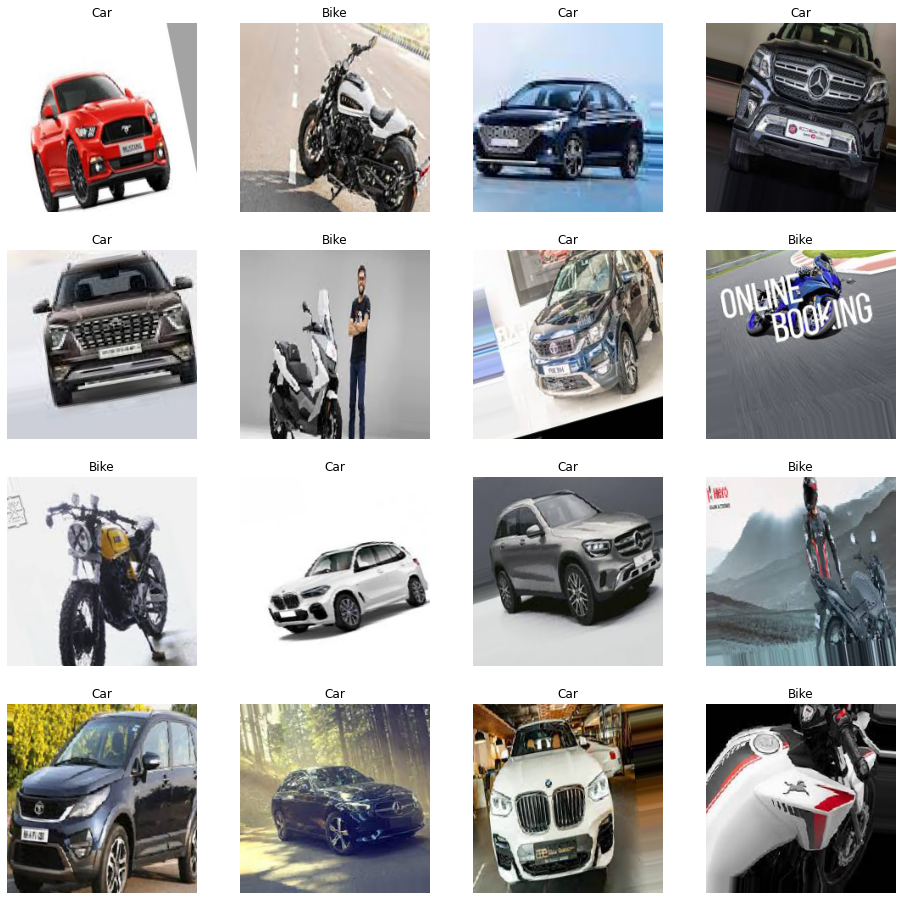

In [ ]:
see_examples(train_set)

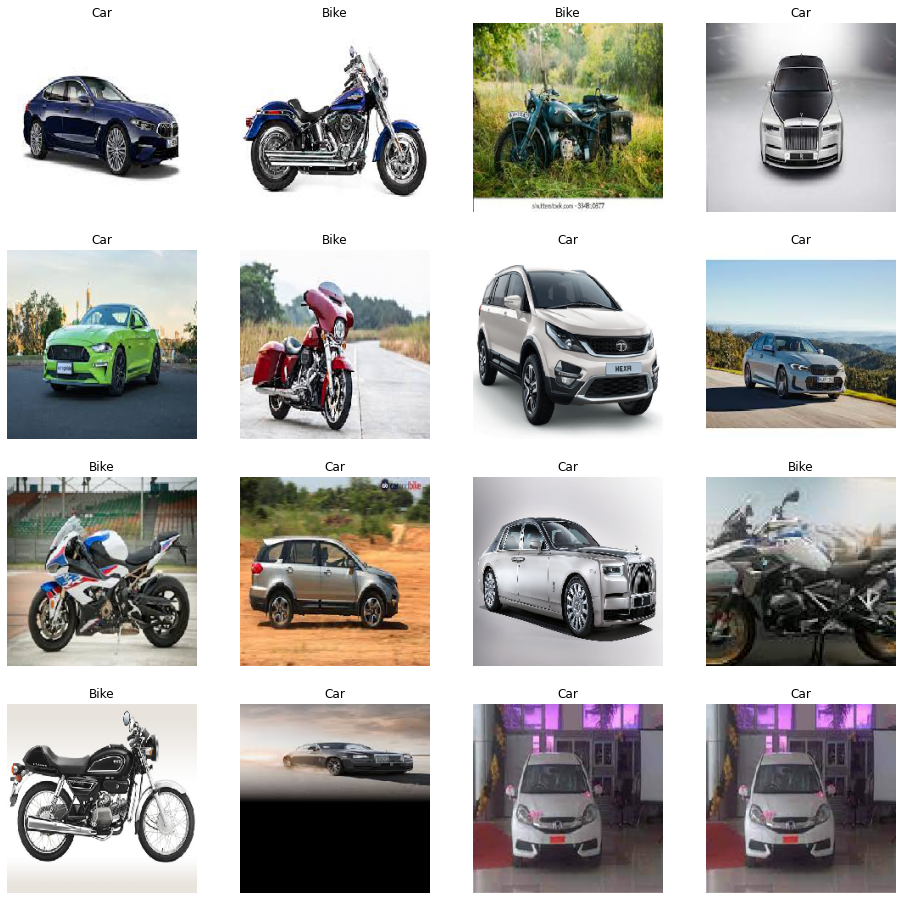

In [ ]:
see_examples(val_set)

In [ ]:
conv_base = efn.EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))
conv_base.trainable=False

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False 

In [ ]:
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),
    
    Dense(units=512,activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=NUM_CLASS, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [ ]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.001)
]

metrics = [
    CategoricalAccuracy(), 
    F1Score(num_classes=NUM_CLASS), 
    Precision(), 
    Recall(), 
#     AUC()
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
history = model.fit(train_set,epochs=epochs, batch_size=BATCH_SIZE,
                  validation_data=val_set,callbacks= callbacks
                             )

Epoch 1/30


C:\Users\mmmmmm\anaconda3\envs\Deeplearning\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


50/50 [==============================] - 246s 5s/step - loss: 0.1200 - categorical_accuracy: 0.9625 - f1_score: 0.9625 - precision: 0.9625 - recall: 0.9625 - val_loss: 0.2120 - val_categorical_accuracy: 0.9625 - val_f1_score: 0.9625 - val_precision: 0.9625 - val_recall: 0.9625 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 242s 5s/step - loss: 0.0314 - categorical_accuracy: 0.9897 - f1_score: 0.9897 - precision: 0.9897 - recall: 0.9897 - val_loss: 0.1748 - val_categorical_accuracy: 0.9725 - val_f1_score: 0.9725 - val_precision: 0.9725 - val_recall: 0.9725 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 260s 5s/step - loss: 0.0153 - categorical_accuracy: 0.9953 - f1_score: 0.9953 - precision: 0.9953 - recall: 0.9953 - val_loss: 0.0841 - val_categorical_accuracy: 0.9875 - val_f1_score: 0.9875 - val_precision: 0.9875 - val_recall: 0.9875 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 257s 5s/step - loss: 0.0192 - categorical_accuracy: 0

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,categorical_accuracy,f1_score,precision,recall,val_loss,val_categorical_accuracy,val_f1_score,val_precision,val_recall,lr
0,0.119964,0.962500,"[0.9625468, 0.9624531]",0.962500,0.962500,0.211968,0.96250,"[0.9611399, 0.96376806]",0.96250,0.96250,0.001
1,0.031432,0.989688,"[0.9897036, 0.9896714]",0.989688,0.989688,0.174795,0.97250,"[0.97172236, 0.973236]",0.97250,0.97250,0.001
2,0.015338,0.995313,"[0.995314, 0.995311]",0.995313,0.995313,0.084130,0.98750,"[0.98734176, 0.9876543]",0.98750,0.98750,0.001
3,0.019244,0.994062,"[0.99406433, 0.9940606]",0.994062,0.994062,0.080421,0.98875,"[0.988622, 0.9888751]",0.98875,0.98875,0.001
4,0.009642,0.996250,"[0.9962477, 0.9962523]",0.996250,0.996250,0.018319,0.99625,"[0.9962453, 0.9962547]",0.99625,0.99625,0.001


In [ ]:
history_df['f1_score'] = history_df['f1_score'].apply(np.mean)
history_df['val_f1_score'] = history_df['val_f1_score'].apply(np.mean)

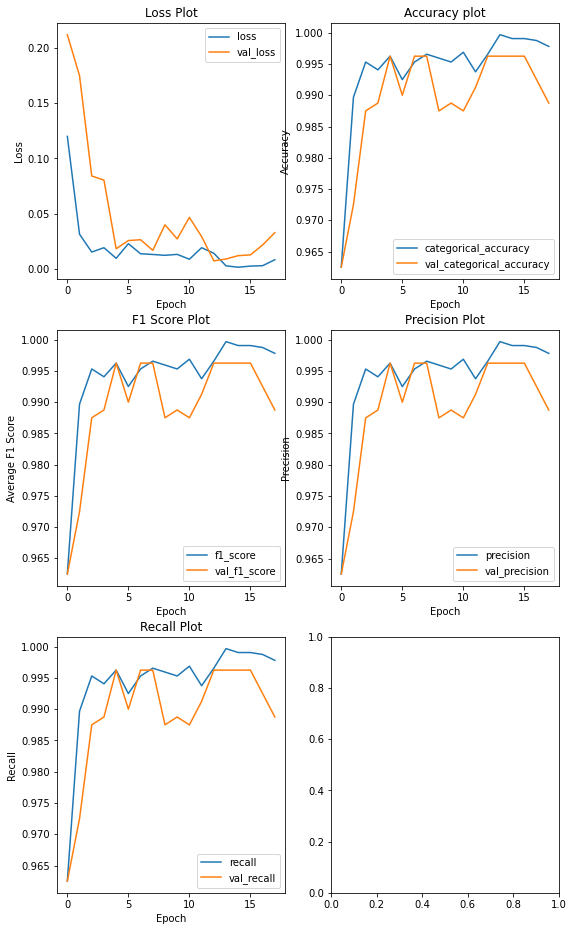

In [ ]:
fig, ax = plt.subplots(figsize=(9,16), nrows=3,ncols=2)
history_df[['loss','val_loss']].plot(ax=ax[0,0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
history_df[['categorical_accuracy','val_categorical_accuracy']].plot(
    ax=ax[0,1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
history_df[['f1_score','val_f1_score']].plot(ax=ax[1,0],xlabel='Epoch',ylabel='Average F1 Score',title='F1 Score Plot')
history_df[['precision','val_precision']].plot(ax=ax[1,1],xlabel='Epoch',ylabel='Precision',title='Precision Plot')
history_df[['recall','val_recall']].plot(ax=ax[2,0],xlabel='Epoch',ylabel='Recall',title='Recall Plot')
plt.show()

In [ ]:
best_model = load_model('best_model.h5')

In [ ]:
val_loss,val_acc, val_f1, val_precision, val_recall = best_model.evaluate(val_set)

C:\Users\mmmmmm\anaconda3\envs\Deeplearning\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


13/13 [==============================] - 32s 2s/step - loss: 0.0074 - categorical_accuracy: 0.9962 - f1_score: 0.9963 - precision: 0.9962 - recall: 0.9962
